# Marginalisation, No systematics

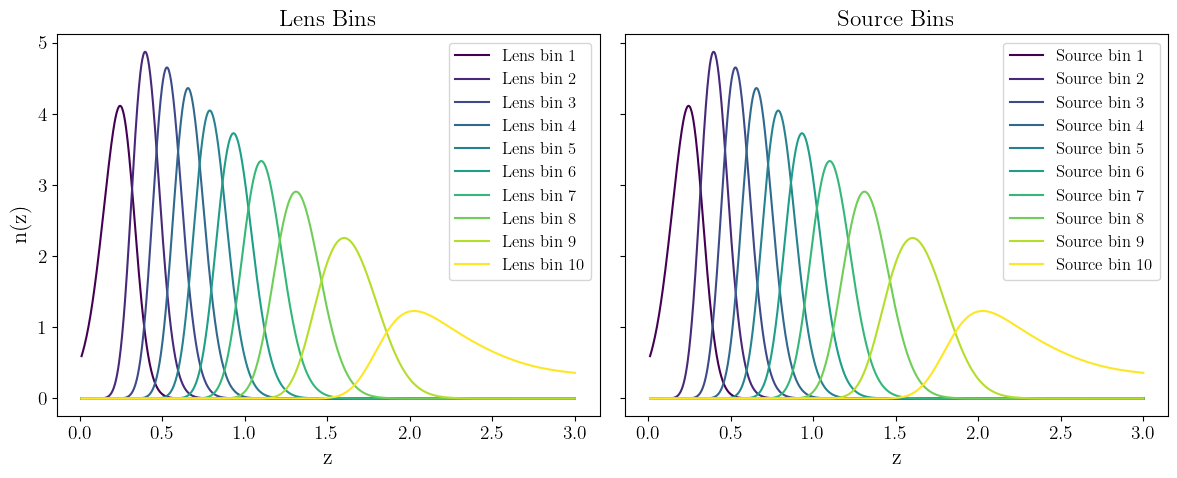

Fisher Forecast 1σ Errors:
Omega_m   : 0.1069
h         : 0.2870
w0        : 0.2462
wa        : 1.0477
bias_0    : 0.4163
bias_1    : 0.3721
bias_2    : 0.3409
bias_3    : 0.3145
bias_4    : 0.2904
bias_5    : 0.2667
bias_6    : 0.2434
bias_7    : 0.2158
bias_8    : 0.1917
bias_9    : 3.0000
Removed no burn in


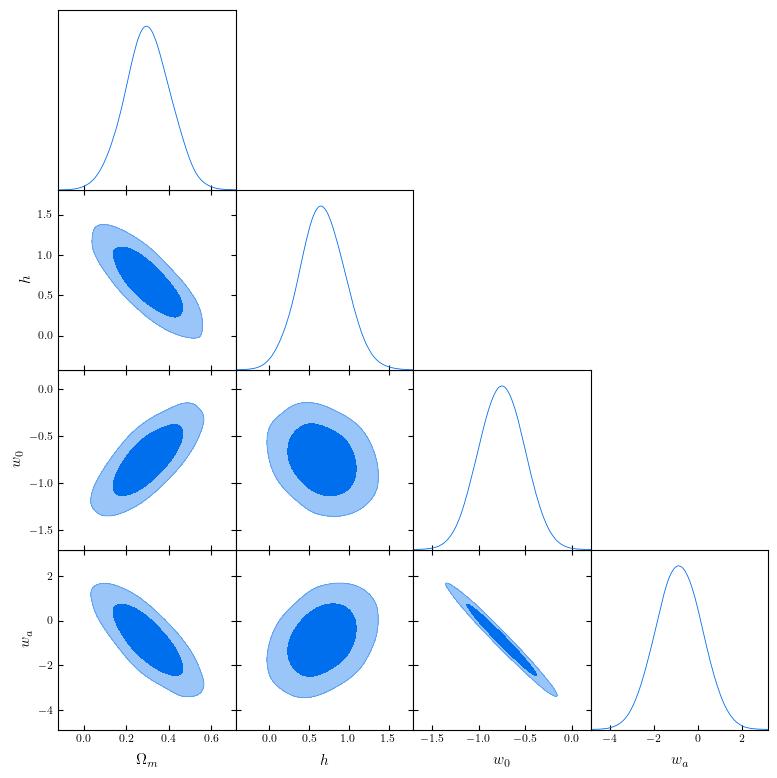

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from marginalisation import Forecast

# --- n(z) and binning utilities ---
def parent_nz(z): return z**2 * np.exp(-(z / 0.176)**0.783)

def make_bins(nz_func, z, nbins):
    from scipy.interpolate import interp1d
    from scipy.stats import norm

    nz = nz_func(z); nz /= np.trapz(nz, z)
    cdf = np.cumsum(nz); cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate(([0], cdf, [1])),
                       np.concatenate(([z[0]], z, [z[-1]])))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))

    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i + 1])
        nz_bin = np.zeros_like(z); nz_bin[mask] = nz[mask]
        nz_bin /= np.trapz(nz_bin, z)
        smoothed = np.zeros_like(z)
        for j, zj in enumerate(z):
            kernel = norm.pdf(z - zj, scale=0.05 * (1 + zj))
            kernel /= np.trapz(kernel, z)
            smoothed[j] = np.trapz(nz_bin * kernel, z)
        smoothed /= np.trapz(smoothed, z)
        bins.append((z.copy(), smoothed.copy()))
    return bins

def ell_eff_uniform_weighting(ell_min, ell_max):
    ells = np.arange(ell_min, ell_max + 1)
    return np.exp(np.mean(np.log(ells)))

# --- Setup ---
z = np.linspace(0.01, 3.0, 1000)
nz_lens = make_bins(parent_nz, z, 10)
nz_src = make_bins(parent_nz, z, 10)

ell_min, ell_max = 100, 2000
ell_eff = ell_eff_uniform_weighting(ell_min, ell_max)
area_deg2 = 14300
n_eff = 27.1
sigma_eps = 0.26
bias_lens = [1.4] * 10
amplitude_prior_std = [3.0] * 10  # Gaussian priors on each lens bias (mean 0)

fid_cosmo = {
    "Omega_m": 0.3,
    "Omega_b": 0.05,
    "h": 0.67,
    "sigma_8": 0.8,
    "n_s": 0.96,
    "w0": -0.752,
    "wa": -0.86
}

# --- Instantiate Forecast ---
forecast = Forecast(
    nz_lens=nz_lens,
    nz_src=nz_src,
    ell=np.array([ell_eff]),
    area_deg2=area_deg2,
    n_eff=n_eff,
    sigma_eps=sigma_eps,
    bias_lens=bias_lens,
    fid_cosmo=fid_cosmo,
    use_ssc=False,
    amplitude_prior_std=amplitude_prior_std
)

# --- Plot n(z) distributions ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
colors = plt.cm.viridis(np.linspace(0, 1, 10))

for i, (z_l, nz_l) in enumerate(nz_lens):
    axes[0].plot(z_l, nz_l, label=f'Lens bin {i+1}', color=colors[i])
axes[0].set_title("Lens Bins")
axes[0].set_xlabel("z")
axes[0].set_ylabel("n(z)")
axes[0].legend()

for i, (z_s, nz_s) in enumerate(nz_src):
    axes[1].plot(z_s, nz_s, label=f'Source bin {i+1}', color=colors[i])
axes[1].set_title("Source Bins")
axes[1].set_xlabel("z")
axes[1].legend()

plt.tight_layout()
plt.show()

# --- Compute Cls and Covariance ---
cl_fid = forecast.compute_cls()
cov, labels = forecast.compute_gk_covariance_matrix(cl_fid, ell_eff, ell_max - ell_min)

# --- Compute Fisher matrix ---
param_names = ["Omega_m", "h", "w0", "wa"]
params, F = forecast.compute_fisher_gk(cl_fid, cov, param_names)

# --- Print parameter errors ---
errors = np.sqrt(np.diag(np.linalg.inv(F)))
print("Fisher Forecast 1σ Errors:")
for p, e in zip(params, errors):
    print(f"{p:10s}: {e:.4f}")

# --- Define truth values ---
truths = fid_cosmo.copy()  # assumes these are the fiducial values for cosmology
# Add bias parameter truth values (assumed to be the fiducial values)
for i in range(len(bias_lens)):
    truths[f"bias_{i}"] = bias_lens[i]

# --- Draw samples from Fisher and plot with GetDist ---
samples, full_params = forecast.draw_fisher_samples(F, params, truths)
forecast.plot_fisher_samples_with_getdist(samples, full_params, truths)

# 5% Marginalisation, no systematics

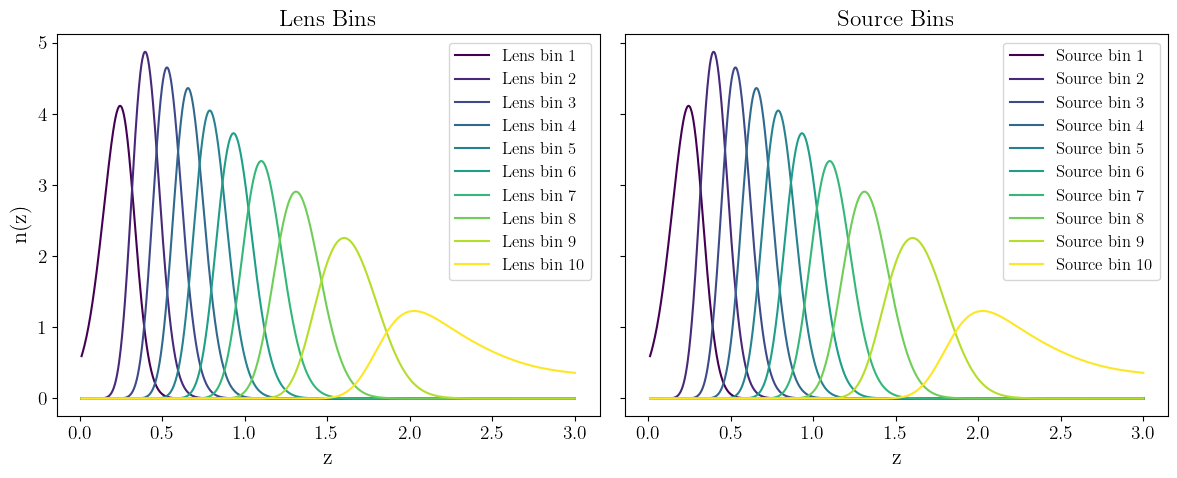

Fisher Forecast 1σ Errors:
Omega_m   : 0.0266
h         : 0.1910
w0        : 0.1137
wa        : 0.4779
bias_0    : 0.0335
bias_1    : 0.0341
bias_2    : 0.0298
bias_3    : 0.0252
bias_4    : 0.0228
bias_5    : 0.0231
bias_6    : 0.0245
bias_7    : 0.0302
bias_8    : 0.0260
bias_9    : 0.0700
Removed no burn in


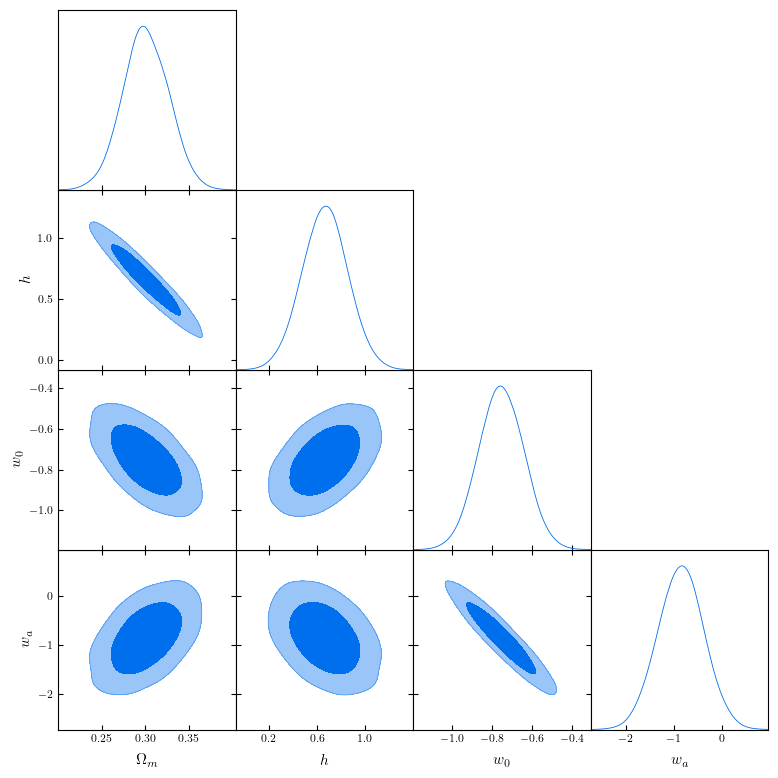

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from marginalisation import Forecast

# --- n(z) and binning utilities ---
def parent_nz(z): return z**2 * np.exp(-(z / 0.176)**0.783)

def make_bins(nz_func, z, nbins):
    from scipy.interpolate import interp1d
    from scipy.stats import norm

    nz = nz_func(z); nz /= np.trapz(nz, z)
    cdf = np.cumsum(nz); cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate(([0], cdf, [1])),
                       np.concatenate(([z[0]], z, [z[-1]])))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))

    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i + 1])
        nz_bin = np.zeros_like(z); nz_bin[mask] = nz[mask]
        nz_bin /= np.trapz(nz_bin, z)
        smoothed = np.zeros_like(z)
        for j, zj in enumerate(z):
            kernel = norm.pdf(z - zj, scale=0.05 * (1 + zj))
            kernel /= np.trapz(kernel, z)
            smoothed[j] = np.trapz(nz_bin * kernel, z)
        smoothed /= np.trapz(smoothed, z)
        bins.append((z.copy(), smoothed.copy()))
    return bins

def ell_eff_uniform_weighting(ell_min, ell_max):
    ells = np.arange(ell_min, ell_max + 1)
    return np.exp(np.mean(np.log(ells)))

# --- Setup ---
z = np.linspace(0.01, 3.0, 1000)
nz_lens = make_bins(parent_nz, z, 10)
nz_src = make_bins(parent_nz, z, 10)

ell_min, ell_max = 100, 2000
ell_eff = ell_eff_uniform_weighting(ell_min, ell_max)
area_deg2 = 14300
n_eff = 27.1
sigma_eps = 0.26
bias_lens = [1.4] * 10
amplitude_prior_std = [0.05* 1.4] * 10  # Gaussian priors on each lens bias (mean 0)

fid_cosmo = {
    "Omega_m": 0.3,
    "Omega_b": 0.05,
    "h": 0.67,
    "sigma_8": 0.8,
    "n_s": 0.96,
    "w0": -0.752,
    "wa": -0.86
}

# --- Instantiate Forecast ---
forecast = Forecast(
    nz_lens=nz_lens,
    nz_src=nz_src,
    ell=np.array([ell_eff]),
    area_deg2=area_deg2,
    n_eff=n_eff,
    sigma_eps=sigma_eps,
    bias_lens=bias_lens,
    fid_cosmo=fid_cosmo,
    use_ssc=False,
    amplitude_prior_std=amplitude_prior_std
)

# --- Plot n(z) distributions ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
colors = plt.cm.viridis(np.linspace(0, 1, 10))

for i, (z_l, nz_l) in enumerate(nz_lens):
    axes[0].plot(z_l, nz_l, label=f'Lens bin {i+1}', color=colors[i])
axes[0].set_title("Lens Bins")
axes[0].set_xlabel("z")
axes[0].set_ylabel("n(z)")
axes[0].legend()

for i, (z_s, nz_s) in enumerate(nz_src):
    axes[1].plot(z_s, nz_s, label=f'Source bin {i+1}', color=colors[i])
axes[1].set_title("Source Bins")
axes[1].set_xlabel("z")
axes[1].legend()

plt.tight_layout()
plt.show()

# --- Compute Cls and Covariance ---
cl_fid = forecast.compute_cls()
cov, labels = forecast.compute_gk_covariance_matrix(cl_fid, ell_eff, ell_max - ell_min)

# --- Compute Fisher matrix ---
param_names = ["Omega_m", "h", "w0", "wa"]
params, F = forecast.compute_fisher_gk(cl_fid, cov, param_names)

# --- Print parameter errors ---
errors = np.sqrt(np.diag(np.linalg.inv(F)))
print("Fisher Forecast 1σ Errors:")
for p, e in zip(params, errors):
    print(f"{p:10s}: {e:.4f}")

# --- Define truth values ---
truths = fid_cosmo.copy()  # assumes these are the fiducial values for cosmology
# Add bias parameter truth values (assumed to be the fiducial values)
for i in range(len(bias_lens)):
    truths[f"bias_{i}"] = bias_lens[i]

# --- Draw samples from Fisher and plot with GetDist ---
samples, full_params = forecast.draw_fisher_samples(F, params, truths)
forecast.plot_fisher_samples_with_getdist(samples, full_params, truths)

# 1% Marginalisation, no systematics

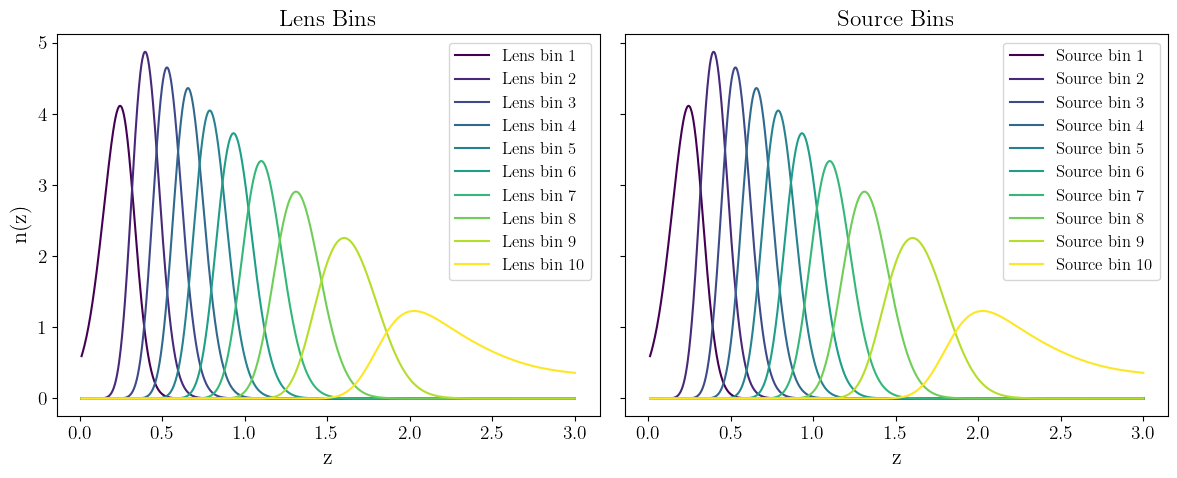

Fisher Forecast 1σ Errors:
Omega_m   : 0.0112
h         : 0.0811
w0        : 0.0896
wa        : 0.4203
bias_0    : 0.0092
bias_1    : 0.0085
bias_2    : 0.0074
bias_3    : 0.0062
bias_4    : 0.0058
bias_5    : 0.0064
bias_6    : 0.0072
bias_7    : 0.0092
bias_8    : 0.0096
bias_9    : 0.0140
Removed no burn in


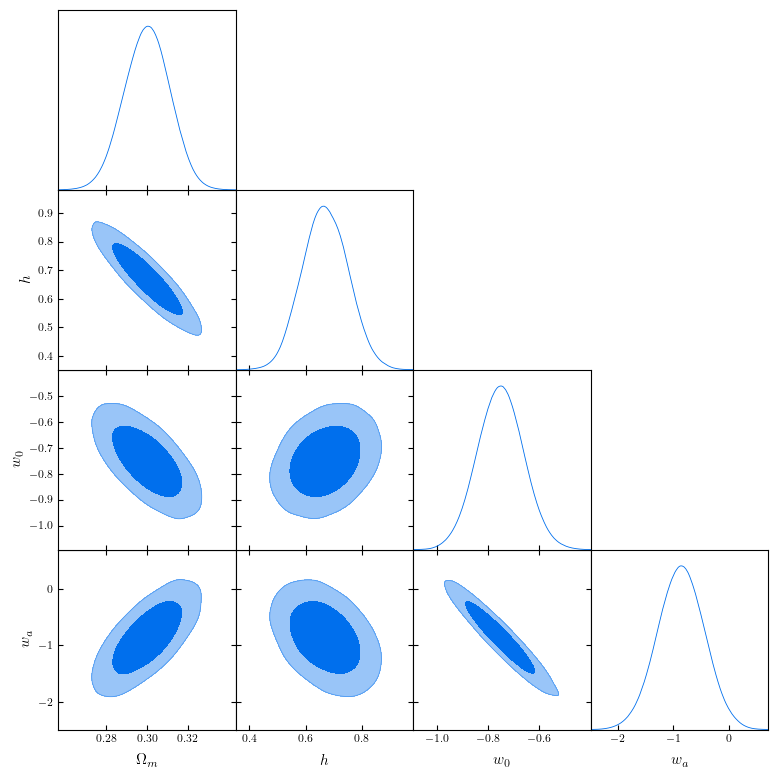

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from marginalisation import Forecast

# --- n(z) and binning utilities ---
def parent_nz(z): return z**2 * np.exp(-(z / 0.176)**0.783)

def make_bins(nz_func, z, nbins):
    from scipy.interpolate import interp1d
    from scipy.stats import norm

    nz = nz_func(z); nz /= np.trapz(nz, z)
    cdf = np.cumsum(nz); cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate(([0], cdf, [1])),
                       np.concatenate(([z[0]], z, [z[-1]])))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))

    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i + 1])
        nz_bin = np.zeros_like(z); nz_bin[mask] = nz[mask]
        nz_bin /= np.trapz(nz_bin, z)
        smoothed = np.zeros_like(z)
        for j, zj in enumerate(z):
            kernel = norm.pdf(z - zj, scale=0.05 * (1 + zj))
            kernel /= np.trapz(kernel, z)
            smoothed[j] = np.trapz(nz_bin * kernel, z)
        smoothed /= np.trapz(smoothed, z)
        bins.append((z.copy(), smoothed.copy()))
    return bins

def ell_eff_uniform_weighting(ell_min, ell_max):
    ells = np.arange(ell_min, ell_max + 1)
    return np.exp(np.mean(np.log(ells)))

# --- Setup ---
z = np.linspace(0.01, 3.0, 1000)
nz_lens = make_bins(parent_nz, z, 10)
nz_src = make_bins(parent_nz, z, 10)

ell_min, ell_max = 100, 2000
ell_eff = ell_eff_uniform_weighting(ell_min, ell_max)
area_deg2 = 14300
n_eff = 27.1
sigma_eps = 0.26
bias_lens = [1.4] * 10
amplitude_prior_std = [0.01* 1.4] * 10  # Gaussian priors on each lens bias (mean 0)

fid_cosmo = {
    "Omega_m": 0.3,
    "Omega_b": 0.05,
    "h": 0.67,
    "sigma_8": 0.8,
    "n_s": 0.96,
    "w0": -0.752,
    "wa": -0.86
}

# --- Instantiate Forecast ---
forecast = Forecast(
    nz_lens=nz_lens,
    nz_src=nz_src,
    ell=np.array([ell_eff]),
    area_deg2=area_deg2,
    n_eff=n_eff,
    sigma_eps=sigma_eps,
    bias_lens=bias_lens,
    fid_cosmo=fid_cosmo,
    use_ssc=False,
    amplitude_prior_std=amplitude_prior_std
)

# --- Plot n(z) distributions ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
colors = plt.cm.viridis(np.linspace(0, 1, 10))

for i, (z_l, nz_l) in enumerate(nz_lens):
    axes[0].plot(z_l, nz_l, label=f'Lens bin {i+1}', color=colors[i])
axes[0].set_title("Lens Bins")
axes[0].set_xlabel("z")
axes[0].set_ylabel("n(z)")
axes[0].legend()

for i, (z_s, nz_s) in enumerate(nz_src):
    axes[1].plot(z_s, nz_s, label=f'Source bin {i+1}', color=colors[i])
axes[1].set_title("Source Bins")
axes[1].set_xlabel("z")
axes[1].legend()

plt.tight_layout()
plt.show()

# --- Compute Cls and Covariance ---
cl_fid = forecast.compute_cls()
cov, labels = forecast.compute_gk_covariance_matrix(cl_fid, ell_eff, ell_max - ell_min)

# --- Compute Fisher matrix ---
param_names = ["Omega_m", "h", "w0", "wa"]
params, F = forecast.compute_fisher_gk(cl_fid, cov, param_names)

# --- Print parameter errors ---
errors = np.sqrt(np.diag(np.linalg.inv(F)))
print("Fisher Forecast 1σ Errors:")
for p, e in zip(params, errors):
    print(f"{p:10s}: {e:.4f}")

# --- Define truth values ---
truths = fid_cosmo.copy()  # assumes these are the fiducial values for cosmology
# Add bias parameter truth values (assumed to be the fiducial values)
for i in range(len(bias_lens)):
    truths[f"bias_{i}"] = bias_lens[i]

# --- Draw samples from Fisher and plot with GetDist ---
samples, full_params = forecast.draw_fisher_samples(F, params, truths)
forecast.plot_fisher_samples_with_getdist(samples, full_params, truths)

# more galaxies, 1% Marginalisation, no systematics

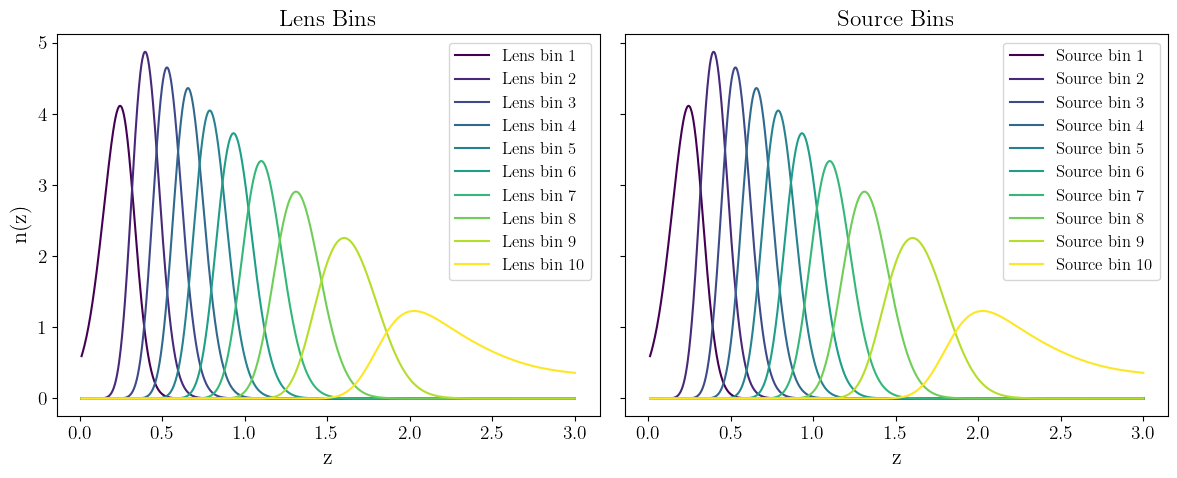

Fisher Forecast 1σ Errors:
Omega_m   : 0.0051
h         : 0.0381
w0        : 0.0167
wa        : 0.0705
bias_0    : 0.0066
bias_1    : 0.0068
bias_2    : 0.0061
bias_3    : 0.0053
bias_4    : 0.0048
bias_5    : 0.0047
bias_6    : 0.0049
bias_7    : 0.0058
bias_8    : 0.0060
bias_9    : 0.0140
Removed no burn in


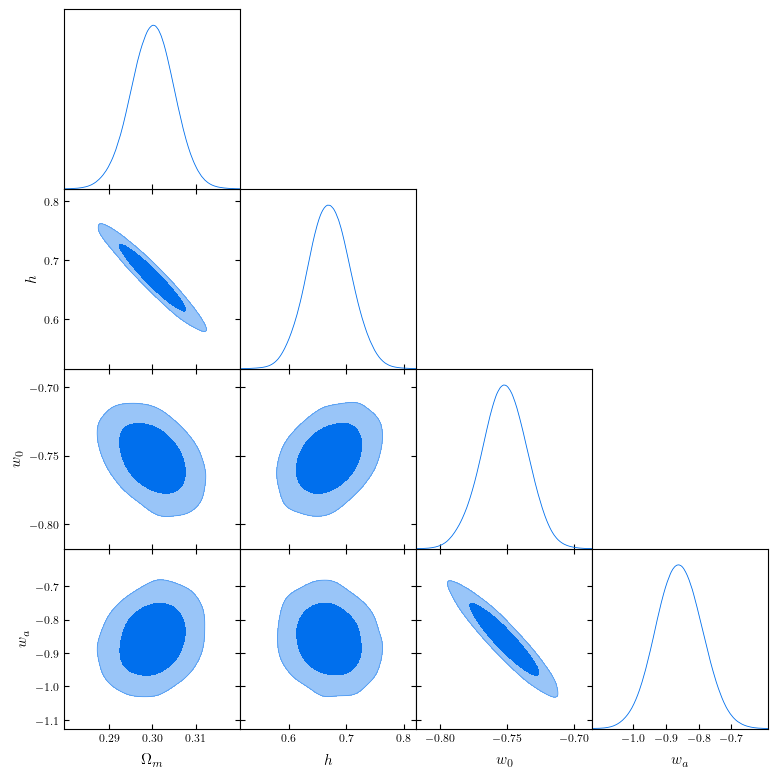

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from marginalisation import Forecast

# --- n(z) and binning utilities ---
def parent_nz(z): return z**2 * np.exp(-(z / 0.176)**0.783)

def make_bins(nz_func, z, nbins):
    from scipy.interpolate import interp1d
    from scipy.stats import norm

    nz = nz_func(z); nz /= np.trapz(nz, z)
    cdf = np.cumsum(nz); cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate(([0], cdf, [1])),
                       np.concatenate(([z[0]], z, [z[-1]])))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))

    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i + 1])
        nz_bin = np.zeros_like(z); nz_bin[mask] = nz[mask]
        nz_bin /= np.trapz(nz_bin, z)
        smoothed = np.zeros_like(z)
        for j, zj in enumerate(z):
            kernel = norm.pdf(z - zj, scale=0.05 * (1 + zj))
            kernel /= np.trapz(kernel, z)
            smoothed[j] = np.trapz(nz_bin * kernel, z)
        smoothed /= np.trapz(smoothed, z)
        bins.append((z.copy(), smoothed.copy()))
    return bins

def ell_eff_uniform_weighting(ell_min, ell_max):
    ells = np.arange(ell_min, ell_max + 1)
    return np.exp(np.mean(np.log(ells)))

# --- Setup ---
z = np.linspace(0.01, 3.0, 1000)
nz_lens = make_bins(parent_nz, z, 10)
nz_src = make_bins(parent_nz, z, 10)

ell_min, ell_max = 100, 2000
ell_eff = ell_eff_uniform_weighting(ell_min, ell_max)
area_deg2 = 14300
n_eff = 27.1 * 100
sigma_eps = 0.26
bias_lens = [1.4] * 10
amplitude_prior_std = [0.01* 1.4] * 10  # Gaussian priors on each lens bias (mean 0)

fid_cosmo = {
    "Omega_m": 0.3,
    "Omega_b": 0.05,
    "h": 0.67,
    "sigma_8": 0.8,
    "n_s": 0.96,
    "w0": -0.752,
    "wa": -0.86
}

# --- Instantiate Forecast ---
forecast = Forecast(
    nz_lens=nz_lens,
    nz_src=nz_src,
    ell=np.array([ell_eff]),
    area_deg2=area_deg2,
    n_eff=n_eff,
    sigma_eps=sigma_eps,
    bias_lens=bias_lens,
    fid_cosmo=fid_cosmo,
    use_ssc=False,
    amplitude_prior_std=amplitude_prior_std
)

# --- Plot n(z) distributions ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
colors = plt.cm.viridis(np.linspace(0, 1, 10))

for i, (z_l, nz_l) in enumerate(nz_lens):
    axes[0].plot(z_l, nz_l, label=f'Lens bin {i+1}', color=colors[i])
axes[0].set_title("Lens Bins")
axes[0].set_xlabel("z")
axes[0].set_ylabel("n(z)")
axes[0].legend()

for i, (z_s, nz_s) in enumerate(nz_src):
    axes[1].plot(z_s, nz_s, label=f'Source bin {i+1}', color=colors[i])
axes[1].set_title("Source Bins")
axes[1].set_xlabel("z")
axes[1].legend()

plt.tight_layout()
plt.show()

# --- Compute Cls and Covariance ---
cl_fid = forecast.compute_cls()
cov, labels = forecast.compute_gk_covariance_matrix(cl_fid, ell_eff, ell_max - ell_min)

# --- Compute Fisher matrix ---
param_names = ["Omega_m", "h", "w0", "wa"]
params, F = forecast.compute_fisher_gk(cl_fid, cov, param_names)

# --- Print parameter errors ---
errors = np.sqrt(np.diag(np.linalg.inv(F)))
print("Fisher Forecast 1σ Errors:")
for p, e in zip(params, errors):
    print(f"{p:10s}: {e:.4f}")

# --- Define truth values ---
truths = fid_cosmo.copy()  # assumes these are the fiducial values for cosmology
# Add bias parameter truth values (assumed to be the fiducial values)
for i in range(len(bias_lens)):
    truths[f"bias_{i}"] = bias_lens[i]

# --- Draw samples from Fisher and plot with GetDist ---
samples, full_params = forecast.draw_fisher_samples(F, params, truths)
forecast.plot_fisher_samples_with_getdist(samples, full_params, truths)

# Marginalisation systematics

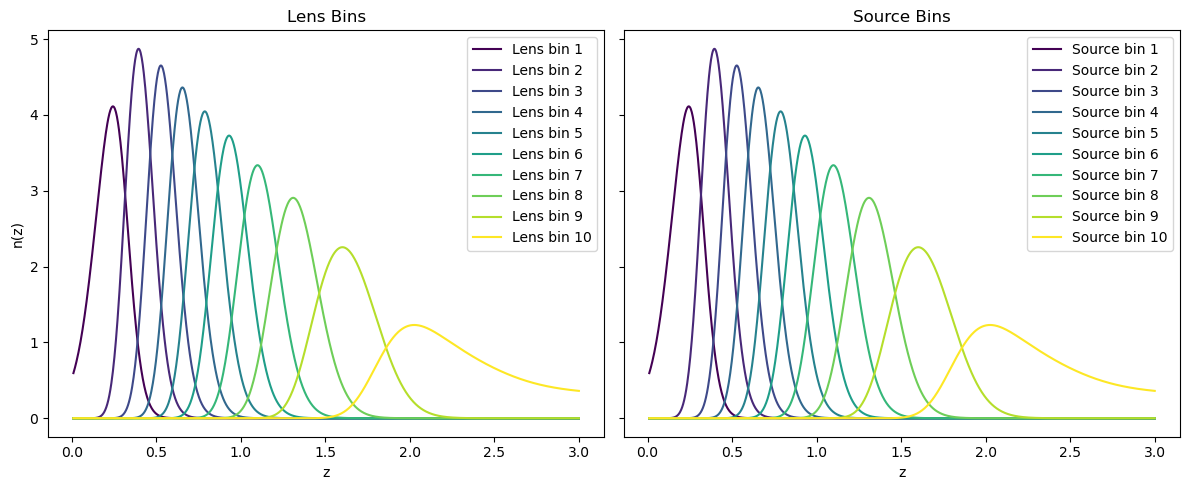

Fisher Forecast 1σ Errors:
Omega_m   : 0.1537
h         : 0.5329
w0        : 0.3898
wa        : 1.5322
bias_0    : 0.5957
bias_1    : 0.5260
bias_2    : 0.4811
bias_3    : 0.4456
bias_4    : 0.4145
bias_5    : 0.3850
bias_6    : 0.3557
bias_7    : 0.3241
bias_8    : 0.2876
bias_9    : 3.0000
delta_z_lens_0: 0.0020
delta_z_lens_1: 0.0014
delta_z_lens_2: 0.0013
delta_z_lens_3: 0.0013
delta_z_lens_4: 0.0013
delta_z_lens_5: 0.0015
delta_z_lens_6: 0.0017
delta_z_lens_7: 0.0019
delta_z_lens_8: 0.0020
delta_z_lens_9: 0.0020
delta_z_src_0: 0.0020
delta_z_src_1: 0.0018
delta_z_src_2: 0.0016
delta_z_src_3: 0.0016
delta_z_src_4: 0.0016
delta_z_src_5: 0.0016
delta_z_src_6: 0.0017
delta_z_src_7: 0.0017
delta_z_src_8: 0.0018
delta_z_src_9: 0.0020
m_src_0   : 0.0050
m_src_1   : 0.0047
m_src_2   : 0.0039
m_src_3   : 0.0035
m_src_4   : 0.0032
m_src_5   : 0.0029
m_src_6   : 0.0027
m_src_7   : 0.0027
m_src_8   : 0.0029
m_src_9   : 0.0036
Removed no burn in


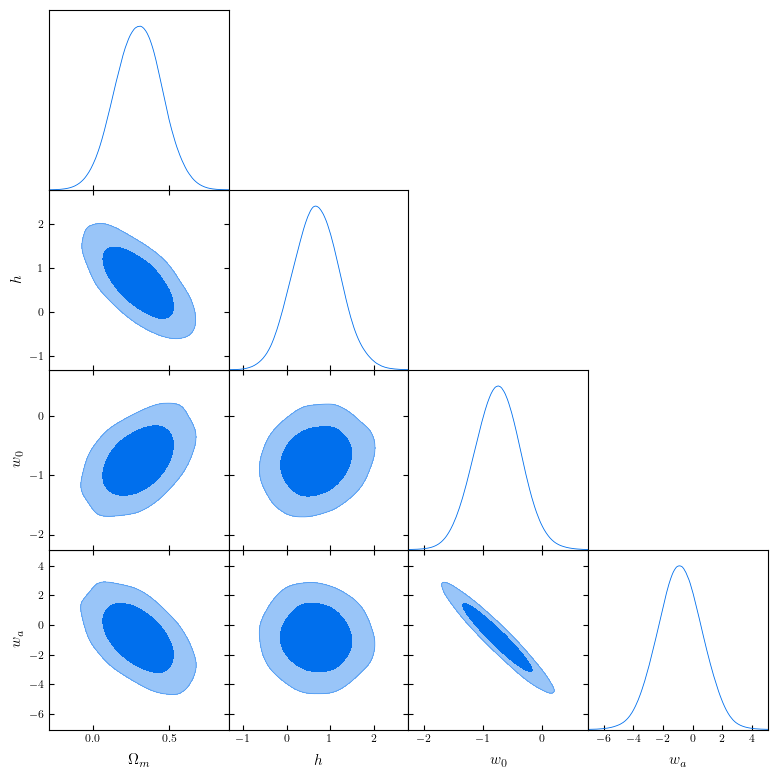

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from marginalisation import Forecast

# --- n(z) and binning utilities ---
def parent_nz(z): return z**2 * np.exp(-(z / 0.176)**0.783)

def make_bins(nz_func, z, nbins):
    from scipy.interpolate import interp1d
    from scipy.stats import norm

    nz = nz_func(z); nz /= np.trapz(nz, z)
    cdf = np.cumsum(nz); cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate(([0], cdf, [1])),
                       np.concatenate(([z[0]], z, [z[-1]])))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))

    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i + 1])
        nz_bin = np.zeros_like(z); nz_bin[mask] = nz[mask]
        nz_bin /= np.trapz(nz_bin, z)
        smoothed = np.zeros_like(z)
        for j, zj in enumerate(z):
            kernel = norm.pdf(z - zj, scale=0.05 * (1 + zj))
            kernel /= np.trapz(kernel, z)
            smoothed[j] = np.trapz(nz_bin * kernel, z)
        smoothed /= np.trapz(smoothed, z)
        bins.append((z.copy(), smoothed.copy()))
    return bins

def ell_eff_uniform_weighting(ell_min, ell_max):
    ells = np.arange(ell_min, ell_max + 1)
    return np.exp(np.mean(np.log(ells)))

# --- Setup ---
z = np.linspace(0.01, 3.0, 1000)
nz_lens = make_bins(parent_nz, z, 10)
nz_src = make_bins(parent_nz, z, 10)

ell_min, ell_max = 100, 2000
ell_eff = ell_eff_uniform_weighting(ell_min, ell_max)
area_deg2 = 14300
n_eff = 27.1
sigma_eps = 0.26
bias_lens = [1.4] * 10
amplitude_prior_std = [3.0] * 10  # Gaussian priors on each lens bias (mean 0)

fid_cosmo = {
    "Omega_m": 0.3,
    "Omega_b": 0.05,
    "h": 0.67,
    "sigma_8": 0.8,
    "n_s": 0.96,
    "w0": -0.752,
    "wa": -0.86
}

# --- Instantiate Forecast ---
forecast = Forecast(
    nz_lens=nz_lens,
    nz_src=nz_src,
    ell=np.array([ell_eff]),
    area_deg2=area_deg2,
    n_eff=n_eff,
    sigma_eps=sigma_eps,
    bias_lens=bias_lens,
    fid_cosmo=fid_cosmo,
    use_ssc=False,
    amplitude_prior_std=amplitude_prior_std,
    marginalize_delta_z_lens=True,
    marginalize_delta_z_src=True,
    marginalize_multiplicative_bias=True
)

# --- Plot n(z) distributions ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
colors = plt.cm.viridis(np.linspace(0, 1, 10))

for i, (z_l, nz_l) in enumerate(nz_lens):
    axes[0].plot(z_l, nz_l, label=f'Lens bin {i+1}', color=colors[i])
axes[0].set_title("Lens Bins")
axes[0].set_xlabel("z")
axes[0].set_ylabel("n(z)")
axes[0].legend()

for i, (z_s, nz_s) in enumerate(nz_src):
    axes[1].plot(z_s, nz_s, label=f'Source bin {i+1}', color=colors[i])
axes[1].set_title("Source Bins")
axes[1].set_xlabel("z")
axes[1].legend()

plt.tight_layout()
plt.show()

# --- Compute Cls and Covariance ---
cl_fid = forecast.compute_cls()
cov, labels = forecast.compute_gk_covariance_matrix(cl_fid, ell_eff, ell_max - ell_min)

# --- Compute Fisher matrix ---
param_names = ["Omega_m", "h", "w0", "wa"]
param_names += [f"delta_z_lens_{i}" for i in range(len(nz_lens))]
param_names += [f"delta_z_src_{i}" for i in range(len(nz_src))]
param_names += [f"m_src_{i}" for i in range(len(nz_src))]
params, F = forecast.compute_fisher_gk(cl_fid, cov, param_names)

# --- Print parameter errors ---
errors = np.sqrt(np.diag(np.linalg.inv(F)))
print("Fisher Forecast 1σ Errors:")
for p, e in zip(params, errors):
    print(f"{p:10s}: {e:.4f}")

# --- Define truth values ---
truths = fid_cosmo.copy()

# Add bias parameters (fiducial = bias_lens values)
for i in range(len(bias_lens)):
    truths[f"bias_{i}"] = bias_lens[i]

# Add delta_z and m_src parameters (fiducial = 0)
for i in range(len(nz_lens)):
    truths[f"delta_z_lens_{i}"] = 0.0
for i in range(len(nz_src)):
    truths[f"delta_z_src_{i}"] = 0.0
    truths[f"m_src_{i}"] = 0.0

# --- Draw samples from Fisher and plot with GetDist ---
samples, full_params = forecast.draw_fisher_samples(F, params, truths)
forecast.plot_fisher_samples_with_getdist(samples, full_params, truths)

# margenalisation systematics 1% error

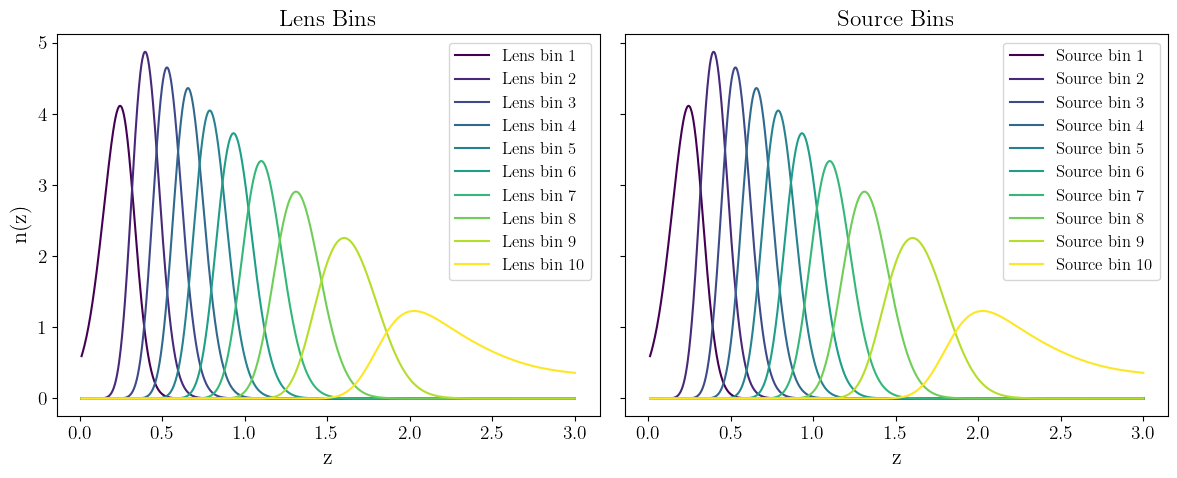

Fisher Forecast 1σ Errors:
Omega_m   : 0.0164
h         : 0.1168
w0        : 0.1520
wa        : 0.7521
bias_0    : 0.0121
bias_1    : 0.0090
bias_2    : 0.0082
bias_3    : 0.0071
bias_4    : 0.0067
bias_5    : 0.0071
bias_6    : 0.0079
bias_7    : 0.0098
bias_8    : 0.0108
bias_9    : 0.0140
delta_z_lens_0: 0.0016
delta_z_lens_1: 0.0011
delta_z_lens_2: 0.0011
delta_z_lens_3: 0.0012
delta_z_lens_4: 0.0013
delta_z_lens_5: 0.0014
delta_z_lens_6: 0.0016
delta_z_lens_7: 0.0018
delta_z_lens_8: 0.0019
delta_z_lens_9: 0.0020
delta_z_src_0: 0.0020
delta_z_src_1: 0.0016
delta_z_src_2: 0.0015
delta_z_src_3: 0.0015
delta_z_src_4: 0.0015
delta_z_src_5: 0.0016
delta_z_src_6: 0.0016
delta_z_src_7: 0.0017
delta_z_src_8: 0.0018
delta_z_src_9: 0.0020
m_src_0   : 0.0050
m_src_1   : 0.0045
m_src_2   : 0.0038
m_src_3   : 0.0033
m_src_4   : 0.0030
m_src_5   : 0.0028
m_src_6   : 0.0027
m_src_7   : 0.0026
m_src_8   : 0.0027
m_src_9   : 0.0031
Removed no burn in


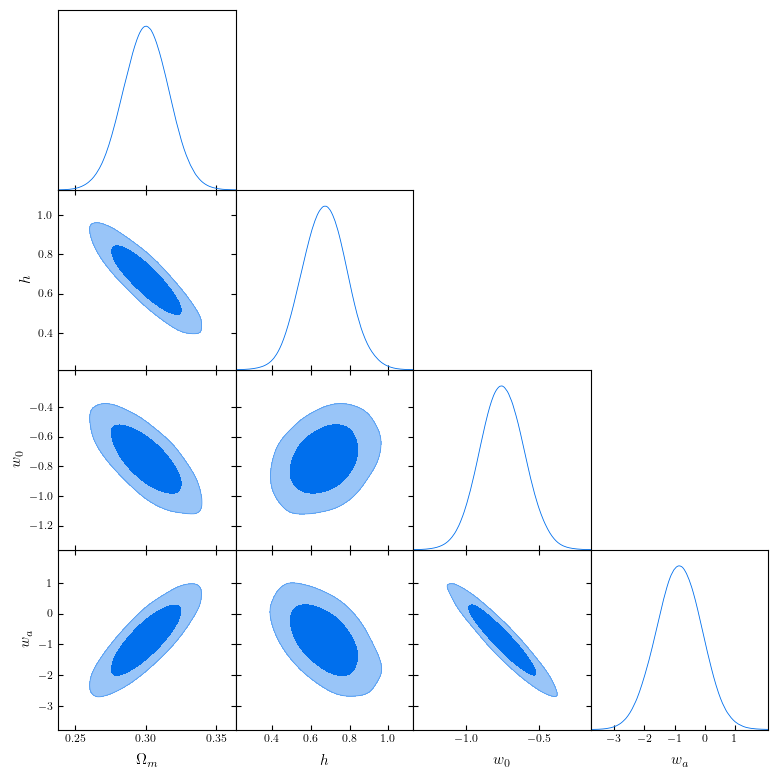

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from marginalisation import Forecast

# --- n(z) and binning utilities ---
def parent_nz(z): return z**2 * np.exp(-(z / 0.176)**0.783)

def make_bins(nz_func, z, nbins):
    from scipy.interpolate import interp1d
    from scipy.stats import norm

    nz = nz_func(z); nz /= np.trapz(nz, z)
    cdf = np.cumsum(nz); cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate(([0], cdf, [1])),
                       np.concatenate(([z[0]], z, [z[-1]])))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))

    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i + 1])
        nz_bin = np.zeros_like(z); nz_bin[mask] = nz[mask]
        nz_bin /= np.trapz(nz_bin, z)
        smoothed = np.zeros_like(z)
        for j, zj in enumerate(z):
            kernel = norm.pdf(z - zj, scale=0.05 * (1 + zj))
            kernel /= np.trapz(kernel, z)
            smoothed[j] = np.trapz(nz_bin * kernel, z)
        smoothed /= np.trapz(smoothed, z)
        bins.append((z.copy(), smoothed.copy()))
    return bins

def ell_eff_uniform_weighting(ell_min, ell_max):
    ells = np.arange(ell_min, ell_max + 1)
    return np.exp(np.mean(np.log(ells)))

# --- Setup ---
z = np.linspace(0.01, 3.0, 1000)
nz_lens = make_bins(parent_nz, z, 10)
nz_src = make_bins(parent_nz, z, 10)

ell_min, ell_max = 100, 2000
ell_eff = ell_eff_uniform_weighting(ell_min, ell_max)
area_deg2 = 14300
n_eff = 27.1
sigma_eps = 0.26
bias_lens = [1.4] * 10
amplitude_prior_std = [0.01* 1.4] * 10  # Gaussian priors on each lens bias (mean 0)

fid_cosmo = {
    "Omega_m": 0.3,
    "Omega_b": 0.05,
    "h": 0.67,
    "sigma_8": 0.8,
    "n_s": 0.96,
    "w0": -0.752,
    "wa": -0.86
}

# --- Instantiate Forecast ---
forecast = Forecast(
    nz_lens=nz_lens,
    nz_src=nz_src,
    ell=np.array([ell_eff]),
    area_deg2=area_deg2,
    n_eff=n_eff,
    sigma_eps=sigma_eps,
    bias_lens=bias_lens,
    fid_cosmo=fid_cosmo,
    use_ssc=False,
    amplitude_prior_std=amplitude_prior_std,
    marginalize_delta_z_lens=True,
    marginalize_delta_z_src=True,
    marginalize_multiplicative_bias=True
)

# --- Plot n(z) distributions ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
colors = plt.cm.viridis(np.linspace(0, 1, 10))

for i, (z_l, nz_l) in enumerate(nz_lens):
    axes[0].plot(z_l, nz_l, label=f'Lens bin {i+1}', color=colors[i])
axes[0].set_title("Lens Bins")
axes[0].set_xlabel("z")
axes[0].set_ylabel("n(z)")
axes[0].legend()

for i, (z_s, nz_s) in enumerate(nz_src):
    axes[1].plot(z_s, nz_s, label=f'Source bin {i+1}', color=colors[i])
axes[1].set_title("Source Bins")
axes[1].set_xlabel("z")
axes[1].legend()

plt.tight_layout()
plt.show()

# --- Compute Cls and Covariance ---
cl_fid = forecast.compute_cls()
cov, labels = forecast.compute_gk_covariance_matrix(cl_fid, ell_eff, ell_max - ell_min)

# --- Compute Fisher matrix ---
param_names = ["Omega_m", "h", "w0", "wa"]
param_names += [f"delta_z_lens_{i}" for i in range(len(nz_lens))]
param_names += [f"delta_z_src_{i}" for i in range(len(nz_src))]
param_names += [f"m_src_{i}" for i in range(len(nz_src))]
params, F = forecast.compute_fisher_gk(cl_fid, cov, param_names)

# --- Print parameter errors ---
errors = np.sqrt(np.diag(np.linalg.inv(F)))
print("Fisher Forecast 1σ Errors:")
for p, e in zip(params, errors):
    print(f"{p:10s}: {e:.4f}")

# --- Define truth values ---
truths = fid_cosmo.copy()

# Add bias parameters (fiducial = bias_lens values)
for i in range(len(bias_lens)):
    truths[f"bias_{i}"] = bias_lens[i]

# Add delta_z and m_src parameters (fiducial = 0)
for i in range(len(nz_lens)):
    truths[f"delta_z_lens_{i}"] = 0.0
for i in range(len(nz_src)):
    truths[f"delta_z_src_{i}"] = 0.0
    truths[f"m_src_{i}"] = 0.0

# --- Draw samples from Fisher and plot with GetDist ---
samples, full_params = forecast.draw_fisher_samples(F, params, truths)
forecast.plot_fisher_samples_with_getdist(samples, full_params, truths)

# marginalisation systematics 1% error 100x more galaxies

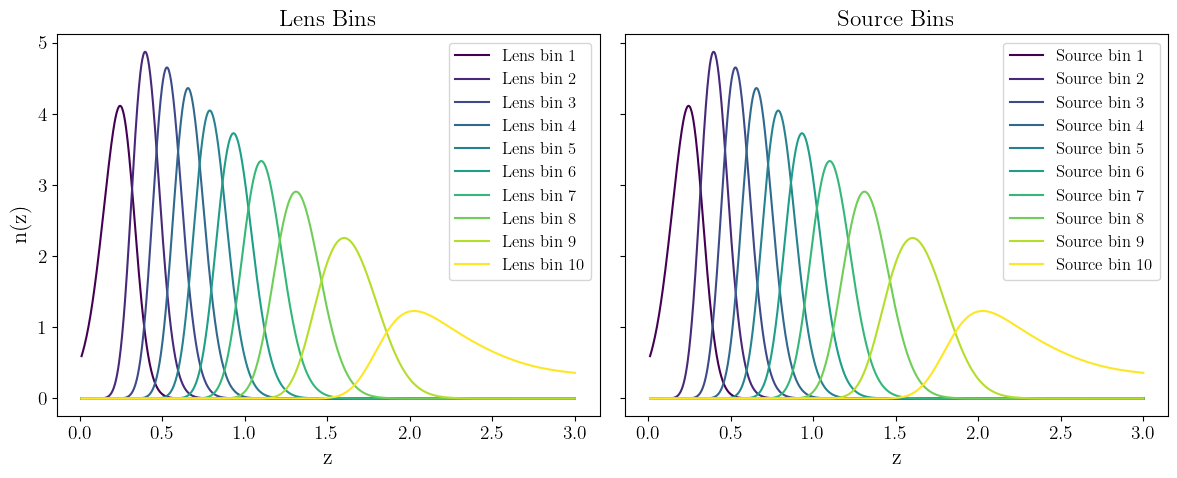

Fisher Forecast 1σ Errors:
Omega_m   : 0.0100
h         : 0.0849
w0        : 0.1073
wa        : 0.4231
bias_0    : 0.0116
bias_1    : 0.0084
bias_2    : 0.0078
bias_3    : 0.0063
bias_4    : 0.0054
bias_5    : 0.0056
bias_6    : 0.0065
bias_7    : 0.0088
bias_8    : 0.0092
bias_9    : 0.0140
delta_z_lens_0: 0.0014
delta_z_lens_1: 0.0008
delta_z_lens_2: 0.0007
delta_z_lens_3: 0.0008
delta_z_lens_4: 0.0008
delta_z_lens_5: 0.0008
delta_z_lens_6: 0.0009
delta_z_lens_7: 0.0012
delta_z_lens_8: 0.0019
delta_z_lens_9: 0.0020
delta_z_src_0: 0.0020
delta_z_src_1: 0.0015
delta_z_src_2: 0.0008
delta_z_src_3: 0.0008
delta_z_src_4: 0.0007
delta_z_src_5: 0.0007
delta_z_src_6: 0.0008
delta_z_src_7: 0.0010
delta_z_src_8: 0.0013
delta_z_src_9: 0.0020
m_src_0   : 0.0050
m_src_1   : 0.0043
m_src_2   : 0.0027
m_src_3   : 0.0020
m_src_4   : 0.0018
m_src_5   : 0.0018
m_src_6   : 0.0019
m_src_7   : 0.0020
m_src_8   : 0.0022
m_src_9   : 0.0026
Removed no burn in


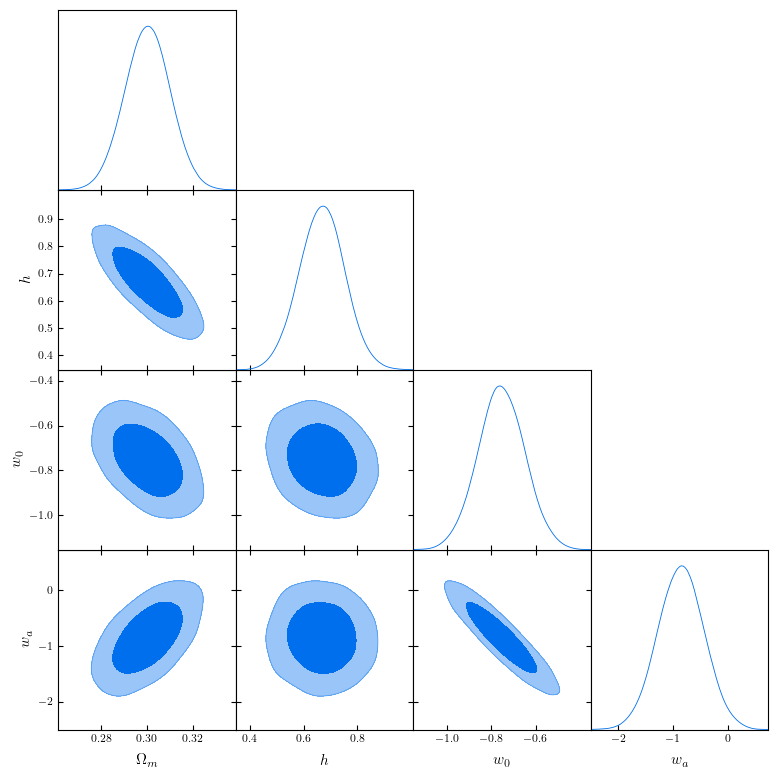

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from marginalisation import Forecast

# --- n(z) and binning utilities ---
def parent_nz(z): return z**2 * np.exp(-(z / 0.176)**0.783)

def make_bins(nz_func, z, nbins):
    from scipy.interpolate import interp1d
    from scipy.stats import norm

    nz = nz_func(z); nz /= np.trapz(nz, z)
    cdf = np.cumsum(nz); cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate(([0], cdf, [1])),
                       np.concatenate(([z[0]], z, [z[-1]])))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))

    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i + 1])
        nz_bin = np.zeros_like(z); nz_bin[mask] = nz[mask]
        nz_bin /= np.trapz(nz_bin, z)
        smoothed = np.zeros_like(z)
        for j, zj in enumerate(z):
            kernel = norm.pdf(z - zj, scale=0.05 * (1 + zj))
            kernel /= np.trapz(kernel, z)
            smoothed[j] = np.trapz(nz_bin * kernel, z)
        smoothed /= np.trapz(smoothed, z)
        bins.append((z.copy(), smoothed.copy()))
    return bins

def ell_eff_uniform_weighting(ell_min, ell_max):
    ells = np.arange(ell_min, ell_max + 1)
    return np.exp(np.mean(np.log(ells)))

# --- Setup ---
z = np.linspace(0.01, 3.0, 1000)
nz_lens = make_bins(parent_nz, z, 10)
nz_src = make_bins(parent_nz, z, 10)

ell_min, ell_max = 100, 2000
ell_eff = ell_eff_uniform_weighting(ell_min, ell_max)
area_deg2 = 14300
n_eff = 27.1 * 100.
sigma_eps = 0.26
bias_lens = [1.4] * 10
amplitude_prior_std = [0.01* 1.4] * 10  # Gaussian priors on each lens bias (mean 0)

fid_cosmo = {
    "Omega_m": 0.3,
    "Omega_b": 0.05,
    "h": 0.67,
    "sigma_8": 0.8,
    "n_s": 0.96,
    "w0": -0.752,
    "wa": -0.86
}

# --- Instantiate Forecast ---
forecast = Forecast(
    nz_lens=nz_lens,
    nz_src=nz_src,
    ell=np.array([ell_eff]),
    area_deg2=area_deg2,
    n_eff=n_eff,
    sigma_eps=sigma_eps,
    bias_lens=bias_lens,
    fid_cosmo=fid_cosmo,
    use_ssc=False,
    amplitude_prior_std=amplitude_prior_std,
    marginalize_delta_z_lens=True,
    marginalize_delta_z_src=True,
    marginalize_multiplicative_bias=True
)

# --- Plot n(z) distributions ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
colors = plt.cm.viridis(np.linspace(0, 1, 10))

for i, (z_l, nz_l) in enumerate(nz_lens):
    axes[0].plot(z_l, nz_l, label=f'Lens bin {i+1}', color=colors[i])
axes[0].set_title("Lens Bins")
axes[0].set_xlabel("z")
axes[0].set_ylabel("n(z)")
axes[0].legend()

for i, (z_s, nz_s) in enumerate(nz_src):
    axes[1].plot(z_s, nz_s, label=f'Source bin {i+1}', color=colors[i])
axes[1].set_title("Source Bins")
axes[1].set_xlabel("z")
axes[1].legend()

plt.tight_layout()
plt.show()

# --- Compute Cls and Covariance ---
cl_fid = forecast.compute_cls()
cov, labels = forecast.compute_gk_covariance_matrix(cl_fid, ell_eff, ell_max - ell_min)

# --- Compute Fisher matrix ---
param_names = ["Omega_m", "h", "w0", "wa"]
param_names += [f"delta_z_lens_{i}" for i in range(len(nz_lens))]
param_names += [f"delta_z_src_{i}" for i in range(len(nz_src))]
param_names += [f"m_src_{i}" for i in range(len(nz_src))]
params, F = forecast.compute_fisher_gk(cl_fid, cov, param_names)

# --- Print parameter errors ---
errors = np.sqrt(np.diag(np.linalg.inv(F)))
print("Fisher Forecast 1σ Errors:")
for p, e in zip(params, errors):
    print(f"{p:10s}: {e:.4f}")

# --- Define truth values ---
truths = fid_cosmo.copy()

# Add bias parameters (fiducial = bias_lens values)
for i in range(len(bias_lens)):
    truths[f"bias_{i}"] = bias_lens[i]

# Add delta_z and m_src parameters (fiducial = 0)
for i in range(len(nz_lens)):
    truths[f"delta_z_lens_{i}"] = 0.0
for i in range(len(nz_src)):
    truths[f"delta_z_src_{i}"] = 0.0
    truths[f"m_src_{i}"] = 0.0

# --- Draw samples from Fisher and plot with GetDist ---
samples, full_params = forecast.draw_fisher_samples(F, params, truths)
forecast.plot_fisher_samples_with_getdist(samples, full_params, truths)

# systematics and 5%

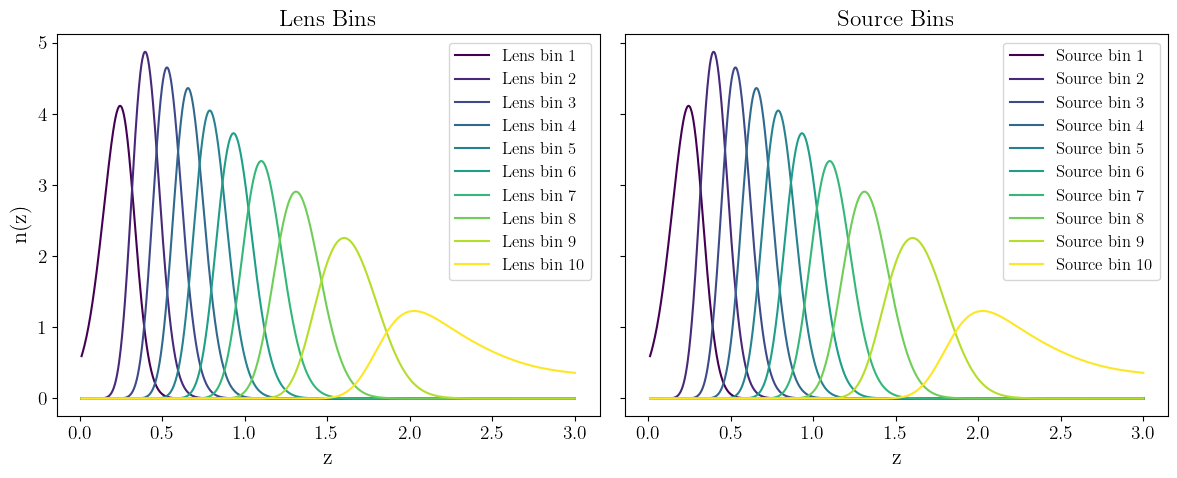

Fisher Forecast 1σ Errors:
Omega_m   : 0.0378
h         : 0.2831
w0        : 0.2195
wa        : 0.9100
bias_0    : 0.0382
bias_1    : 0.0381
bias_2    : 0.0327
bias_3    : 0.0264
bias_4    : 0.0234
bias_5    : 0.0252
bias_6    : 0.0290
bias_7    : 0.0386
bias_8    : 0.0334
bias_9    : 0.0700
delta_z_lens_0: 0.0018
delta_z_lens_1: 0.0012
delta_z_lens_2: 0.0011
delta_z_lens_3: 0.0012
delta_z_lens_4: 0.0013
delta_z_lens_5: 0.0014
delta_z_lens_6: 0.0016
delta_z_lens_7: 0.0018
delta_z_lens_8: 0.0020
delta_z_lens_9: 0.0020
delta_z_src_0: 0.0020
delta_z_src_1: 0.0017
delta_z_src_2: 0.0015
delta_z_src_3: 0.0015
delta_z_src_4: 0.0015
delta_z_src_5: 0.0016
delta_z_src_6: 0.0016
delta_z_src_7: 0.0017
delta_z_src_8: 0.0018
delta_z_src_9: 0.0020
m_src_0   : 0.0050
m_src_1   : 0.0045
m_src_2   : 0.0039
m_src_3   : 0.0034
m_src_4   : 0.0031
m_src_5   : 0.0028
m_src_6   : 0.0027
m_src_7   : 0.0027
m_src_8   : 0.0028
m_src_9   : 0.0035
Removed no burn in


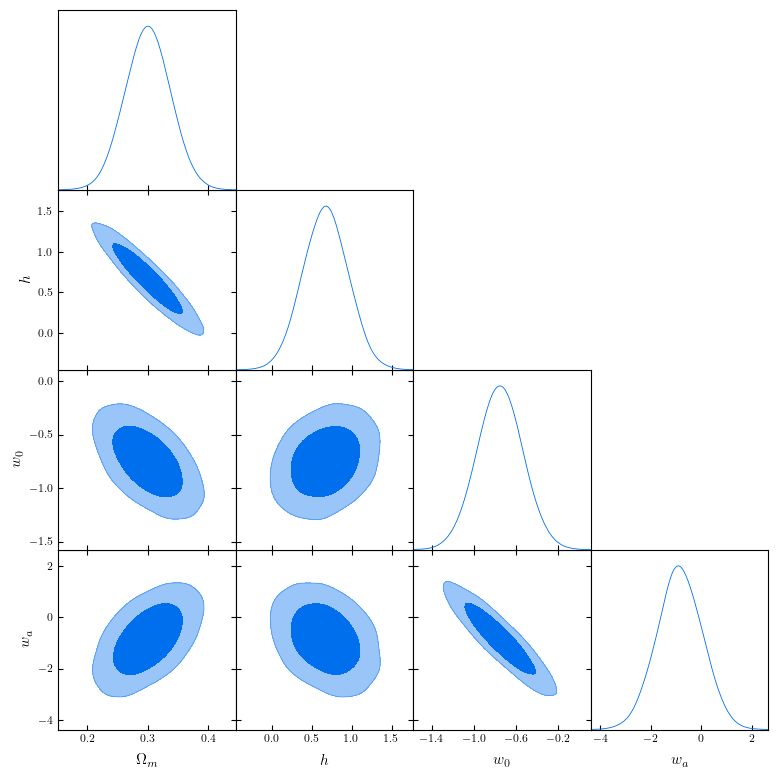

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from marginalisation import Forecast

# --- n(z) and binning utilities ---
def parent_nz(z): return z**2 * np.exp(-(z / 0.176)**0.783)

def make_bins(nz_func, z, nbins):
    from scipy.interpolate import interp1d
    from scipy.stats import norm

    nz = nz_func(z); nz /= np.trapz(nz, z)
    cdf = np.cumsum(nz); cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate(([0], cdf, [1])),
                       np.concatenate(([z[0]], z, [z[-1]])))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))

    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i + 1])
        nz_bin = np.zeros_like(z); nz_bin[mask] = nz[mask]
        nz_bin /= np.trapz(nz_bin, z)
        smoothed = np.zeros_like(z)
        for j, zj in enumerate(z):
            kernel = norm.pdf(z - zj, scale=0.05 * (1 + zj))
            kernel /= np.trapz(kernel, z)
            smoothed[j] = np.trapz(nz_bin * kernel, z)
        smoothed /= np.trapz(smoothed, z)
        bins.append((z.copy(), smoothed.copy()))
    return bins

def ell_eff_uniform_weighting(ell_min, ell_max):
    ells = np.arange(ell_min, ell_max + 1)
    return np.exp(np.mean(np.log(ells)))

# --- Setup ---
z = np.linspace(0.01, 3.0, 1000)
nz_lens = make_bins(parent_nz, z, 10)
nz_src = make_bins(parent_nz, z, 10)

ell_min, ell_max = 100, 2000
ell_eff = ell_eff_uniform_weighting(ell_min, ell_max)
area_deg2 = 14300
n_eff = 27.1
sigma_eps = 0.26
bias_lens = [1.4] * 10
amplitude_prior_std = [0.05* 1.4] * 10  # Gaussian priors on each lens bias (mean 0)

fid_cosmo = {
    "Omega_m": 0.3,
    "Omega_b": 0.05,
    "h": 0.67,
    "sigma_8": 0.8,
    "n_s": 0.96,
    "w0": -0.752,
    "wa": -0.86
}

# --- Instantiate Forecast ---
forecast = Forecast(
    nz_lens=nz_lens,
    nz_src=nz_src,
    ell=np.array([ell_eff]),
    area_deg2=area_deg2,
    n_eff=n_eff,
    sigma_eps=sigma_eps,
    bias_lens=bias_lens,
    fid_cosmo=fid_cosmo,
    use_ssc=False,
    amplitude_prior_std=amplitude_prior_std,
    marginalize_delta_z_lens=True,
    marginalize_delta_z_src=True,
    marginalize_multiplicative_bias=True
)

# --- Plot n(z) distributions ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
colors = plt.cm.viridis(np.linspace(0, 1, 10))

for i, (z_l, nz_l) in enumerate(nz_lens):
    axes[0].plot(z_l, nz_l, label=f'Lens bin {i+1}', color=colors[i])
axes[0].set_title("Lens Bins")
axes[0].set_xlabel("z")
axes[0].set_ylabel("n(z)")
axes[0].legend()

for i, (z_s, nz_s) in enumerate(nz_src):
    axes[1].plot(z_s, nz_s, label=f'Source bin {i+1}', color=colors[i])
axes[1].set_title("Source Bins")
axes[1].set_xlabel("z")
axes[1].legend()

plt.tight_layout()
plt.show()

# --- Compute Cls and Covariance ---
cl_fid = forecast.compute_cls()
cov, labels = forecast.compute_gk_covariance_matrix(cl_fid, ell_eff, ell_max - ell_min)

# --- Compute Fisher matrix ---
param_names = ["Omega_m", "h", "w0", "wa"]
param_names += [f"delta_z_lens_{i}" for i in range(len(nz_lens))]
param_names += [f"delta_z_src_{i}" for i in range(len(nz_src))]
param_names += [f"m_src_{i}" for i in range(len(nz_src))]
params, F = forecast.compute_fisher_gk(cl_fid, cov, param_names)

# --- Print parameter errors ---
errors = np.sqrt(np.diag(np.linalg.inv(F)))
print("Fisher Forecast 1σ Errors:")
for p, e in zip(params, errors):
    print(f"{p:10s}: {e:.4f}")

# --- Define truth values ---
truths = fid_cosmo.copy()

# Add bias parameters (fiducial = bias_lens values)
for i in range(len(bias_lens)):
    truths[f"bias_{i}"] = bias_lens[i]

# Add delta_z and m_src parameters (fiducial = 0)
for i in range(len(nz_lens)):
    truths[f"delta_z_lens_{i}"] = 0.0
for i in range(len(nz_src)):
    truths[f"delta_z_src_{i}"] = 0.0
    truths[f"m_src_{i}"] = 0.0

# --- Draw samples from Fisher and plot with GetDist ---
samples, full_params = forecast.draw_fisher_samples(F, params, truths)
forecast.plot_fisher_samples_with_getdist(samples, full_params, truths)